In [2]:

import os
import glob
import random
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
from torch import nn
import torch.optim as optim

# Sklearn: Preprocessing, Model Selection, Metrics
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report, 
    confusion_matrix
)

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from collections import Counter

# Fast Progress Bar
from fastprogress.fastprogress import master_bar, progress_bar


torch.set_default_dtype(torch.float32)

# seed initialization
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:

df = pd.read_csv("./diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
df['Outcome'].value_counts() 

Outcome
0    500
1    268
Name: count, dtype: int64

In [6]:
cols = df.columns.tolist()
cols.remove('Outcome')

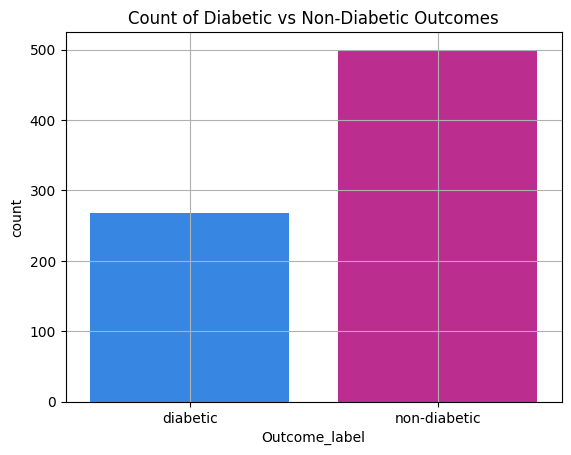

In [7]:
t = df.copy(deep = True)

t['Outcome_label'] = t['Outcome'].map({0: 'non-diabetic', 1: 'diabetic'})
sns.countplot(x='Outcome_label', data=t, hue='Outcome_label',palette={'#1A85FF', '#D41599'})
plt.title('Count of Diabetic vs Non-Diabetic Outcomes')
plt.grid()
plt.show()


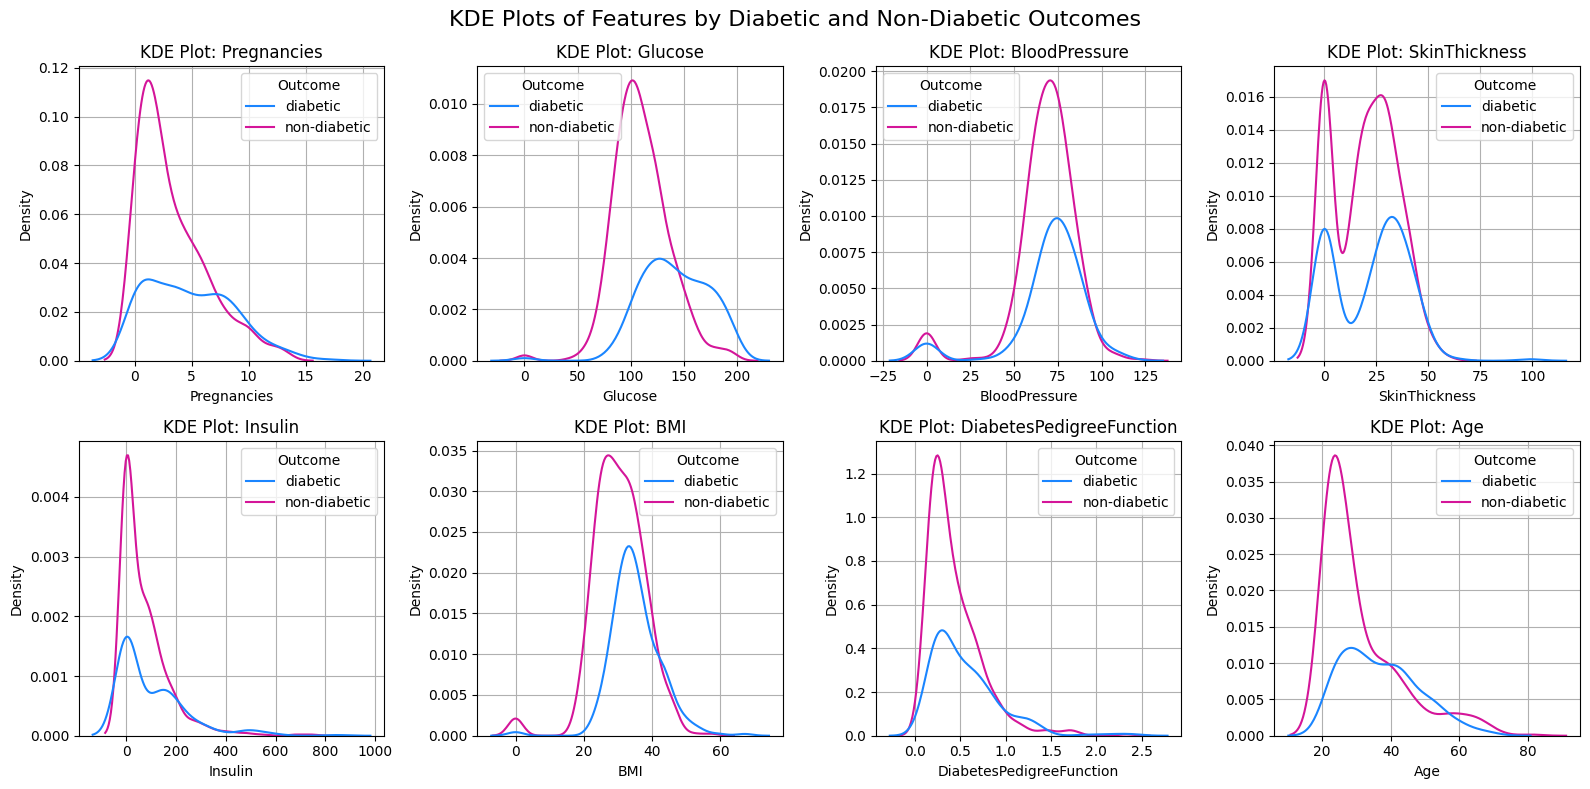

In [8]:


cols = 4  
num_columns = len(df.columns) -1

rows = (num_columns // cols) + (num_columns % cols > 0) 
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, rows * 4))
axes = axes.flatten()
columns = df.columns.tolist()
columns.remove('Outcome')
for i, col in enumerate(columns):
    sns.kdeplot(x=col, data=df, ax=axes[i], hue=df['Outcome'].map({0: 'non-diabetic', 1: 'diabetic'}), palette={'#1A85FF', '#D41599'})
    axes[i].set_title(f'KDE Plot: {col}')
    axes[i].grid(True)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.suptitle('KDE Plots of Features by Diabetic and Non-Diabetic Outcomes', fontsize=16)
plt.tight_layout()
plt.show()



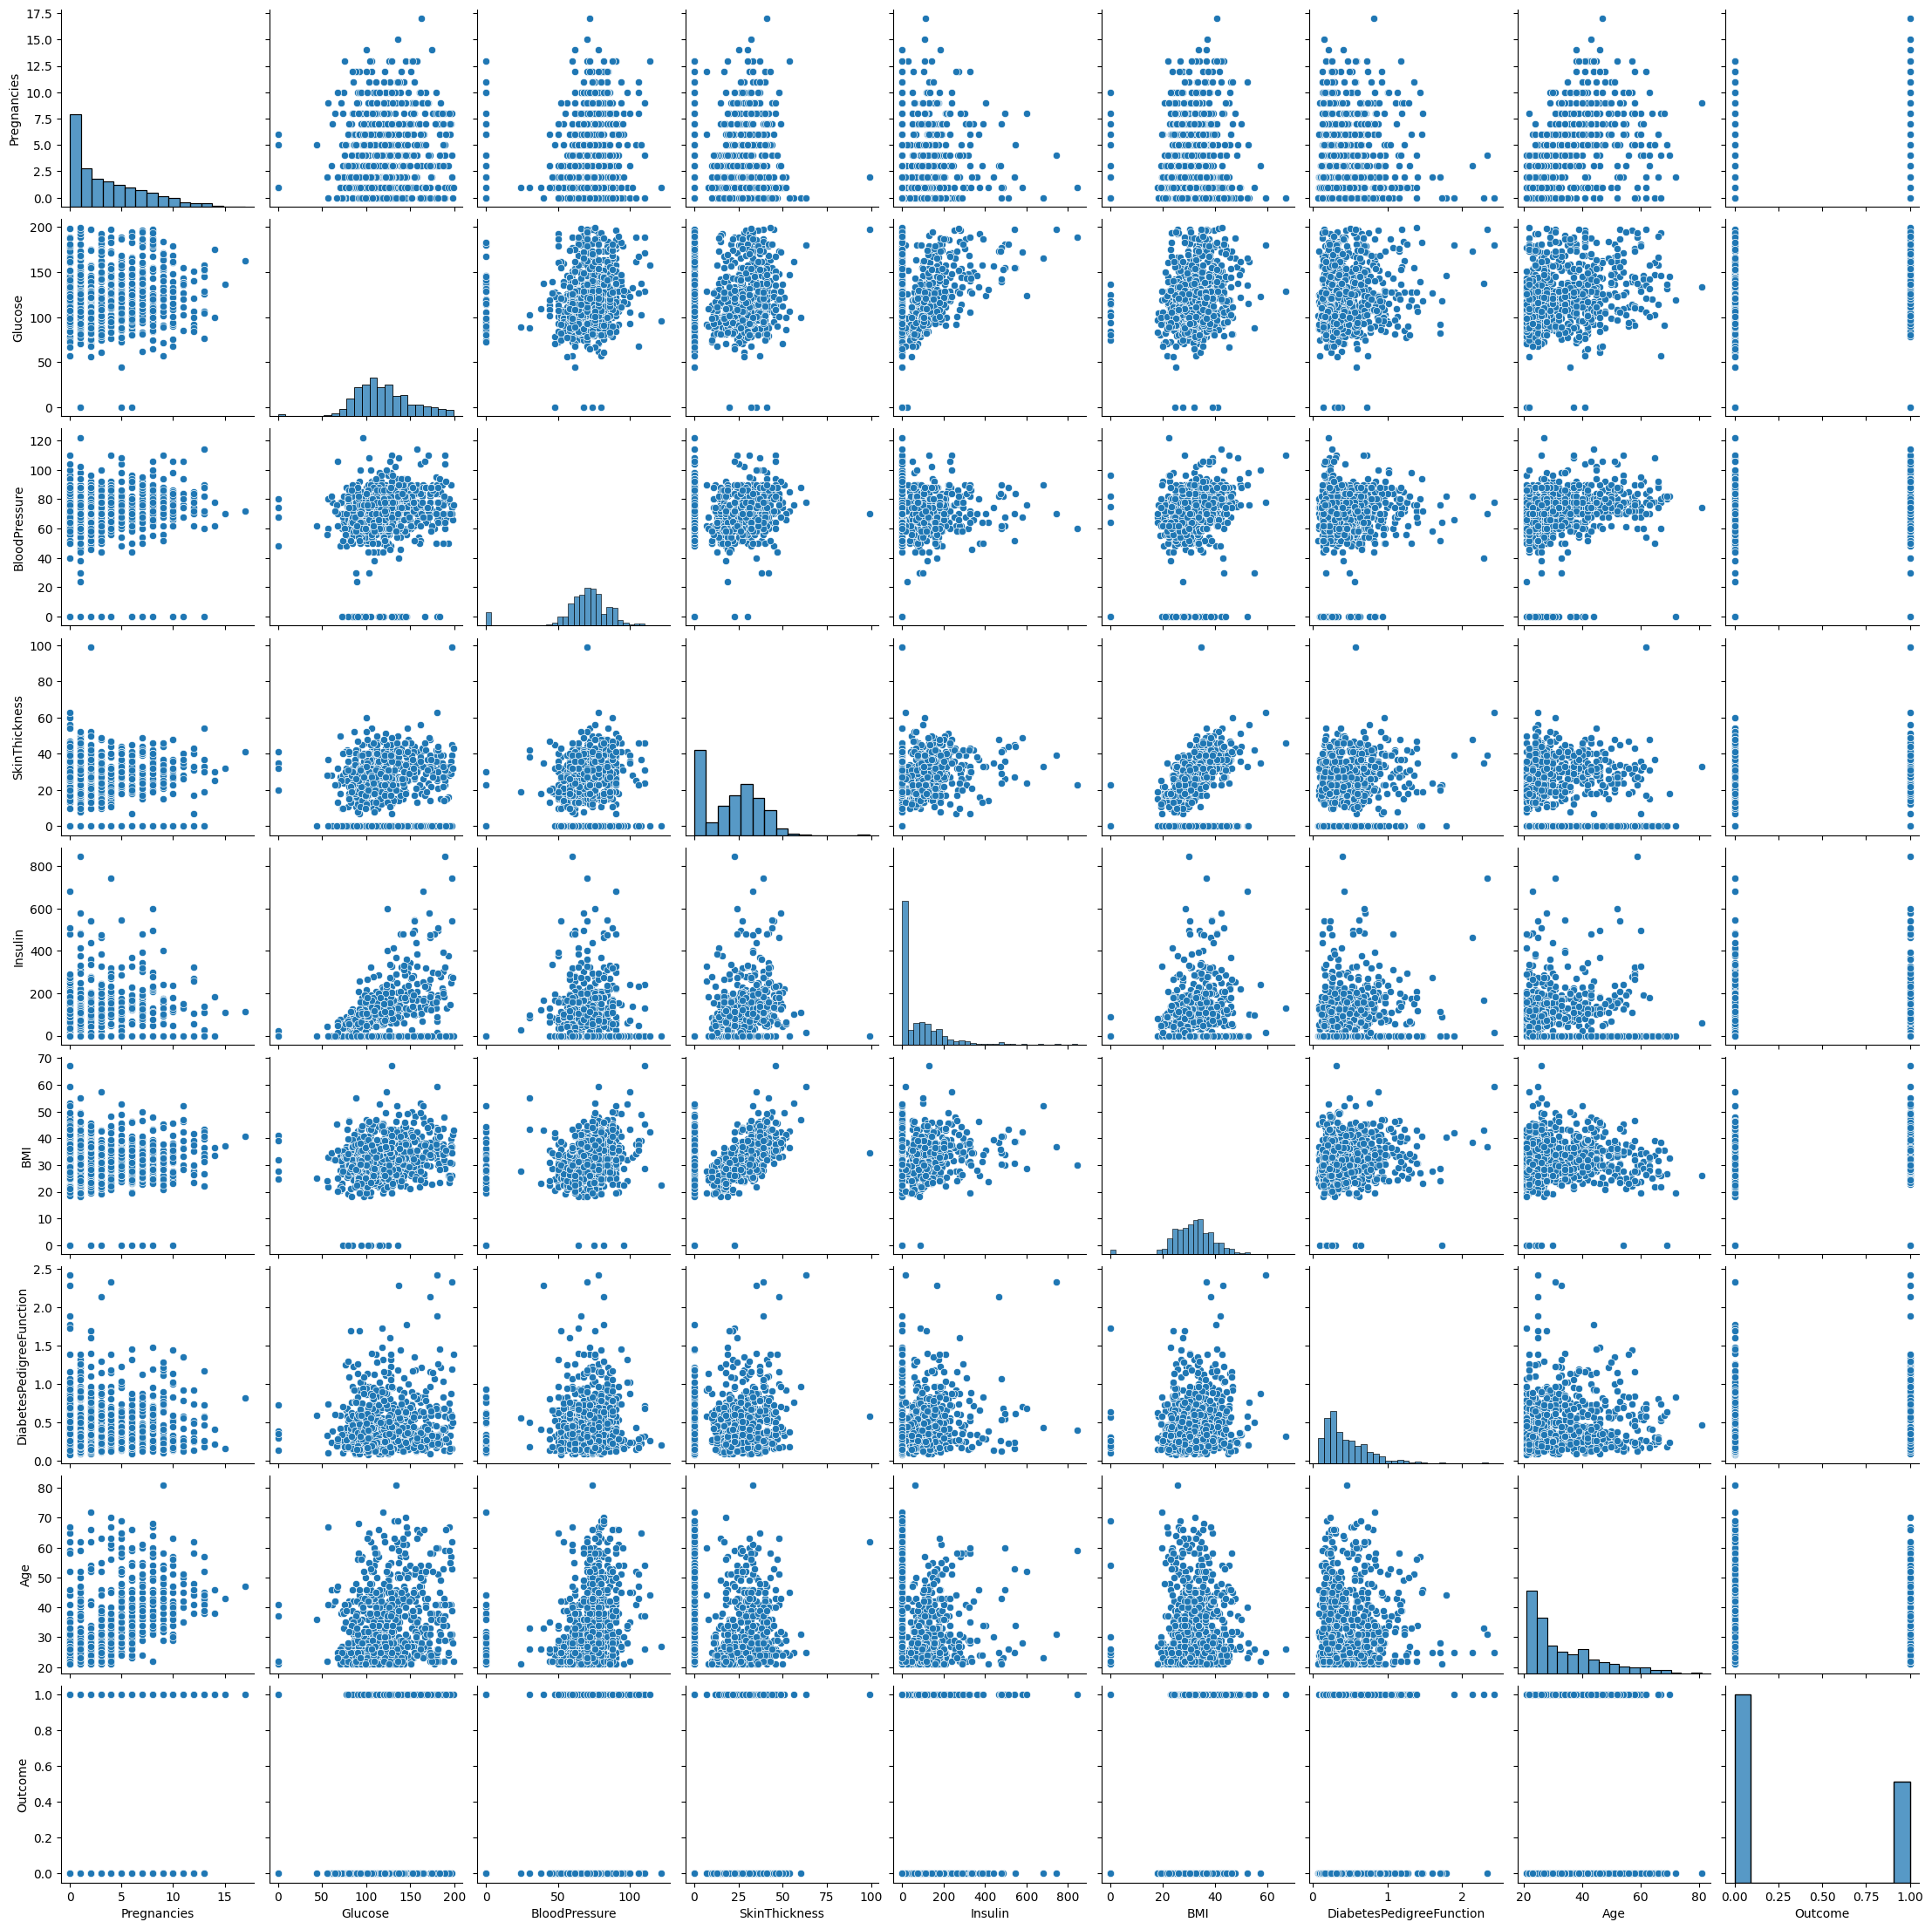

In [9]:
custom_palette = {'#1A85FF', '#D41599'}

sns.pairplot(data = df, )

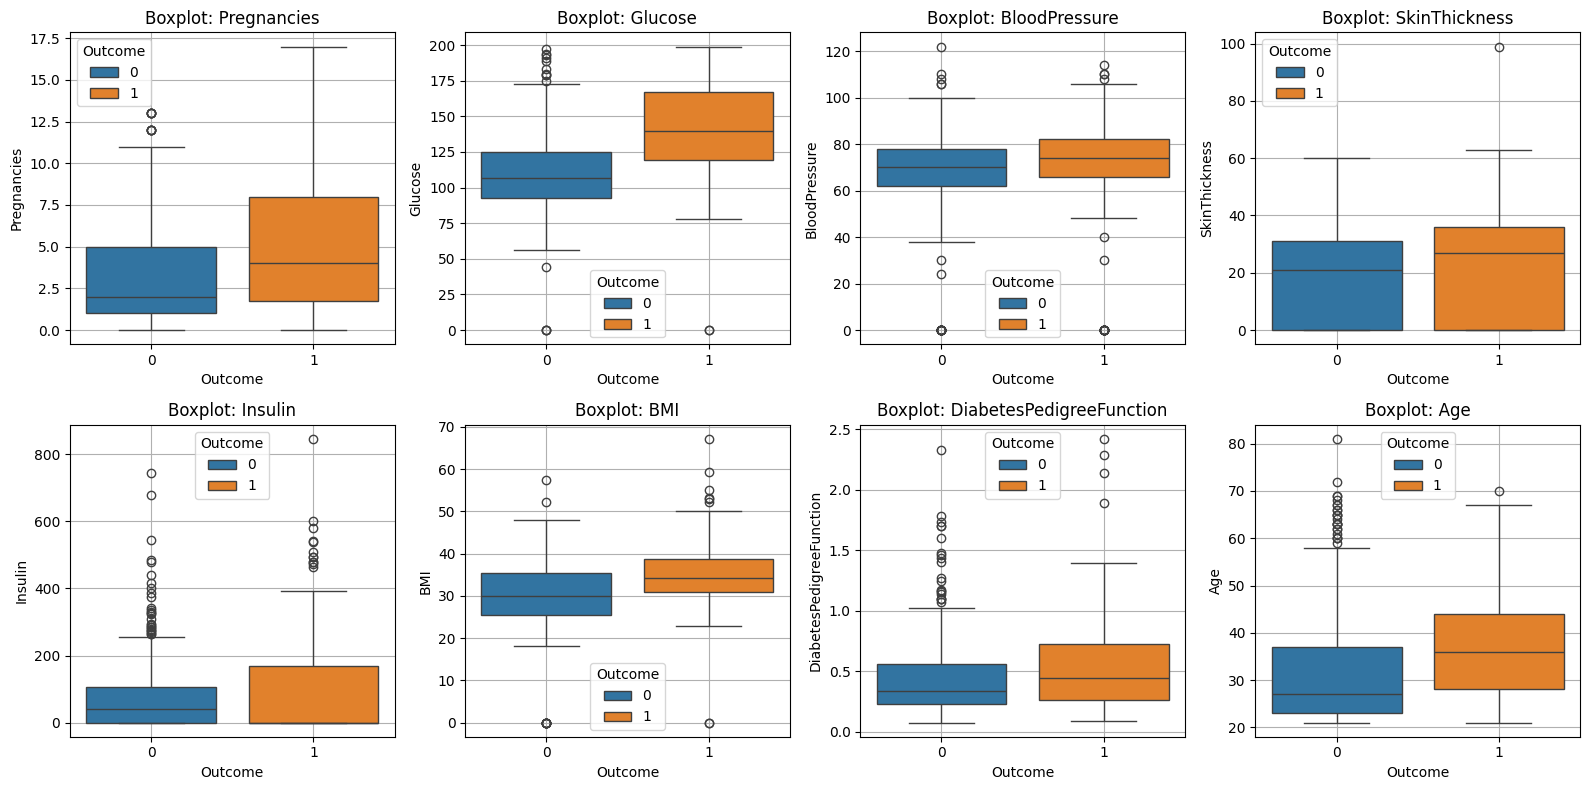

In [10]:

num_columns = len(df.columns) -1


cols = 4  
rows = (num_columns // cols) + (num_columns % cols > 0) 
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, rows * 4))
axes = axes.flatten()
columns = df.columns.tolist()
columns.remove('Outcome')
for i, col in enumerate(columns):
    sns.boxplot(x='Outcome', y=col, data=df, ax=axes[i] , hue = 'Outcome')
    axes[i].set_title(f'Boxplot: {col}')
    axes[i].grid(True)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()



In [11]:
# replacing 0 values with np.nan
df['Glucose'].replace(0, np.nan, inplace=True)
df['BMI'].replace(0, np.nan, inplace=True)
df['Insulin'].replace(0, np.nan, inplace=True)
df['SkinThickness'].replace(0, np.nan, inplace=True)

In [12]:


cols = df.columns.tolist()
cols.remove('Outcome')

X, y = df[cols], df['Outcome'].values

# splitting data train, validation, and test sets (80% train, 10% val, 10% test) with stratification
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11, random_state=42, stratify=y_train_val)

# pipeline for preprocessing: imputation & scaling
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', RobustScaler())  
])

# Preprocess training, validation, and test sets
X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)  
X_test = pipeline.transform(X_test)

# applying SMOTE in train set
counts_before_smote = Counter(y_train)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
counts_after_smote = Counter(y_train_smote)



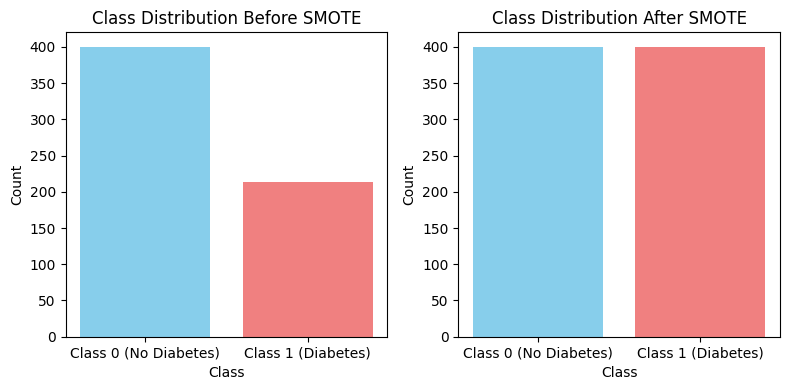

In [13]:
# visualizing before and after applying SMOTE
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1) 
plt.bar(counts_before_smote.keys(), counts_before_smote.values(), color=['skyblue', 'lightcoral'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution Before SMOTE')
plt.xticks([0, 1], labels=['Class 0 (No Diabetes)', 'Class 1 (Diabetes)'])


plt.subplot(1, 2, 2)  
plt.bar(counts_after_smote.keys(), counts_after_smote.values(), color=['skyblue', 'lightcoral'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution After SMOTE')
plt.xticks([0, 1], labels=['Class 0 (No Diabetes)', 'Class 1 (Diabetes)'])


plt.tight_layout() 
plt.show()

In [14]:
# converting to tensors 
device = torch.device("mps")

X_train= torch.tensor(X_train_smote, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_smote, dtype=torch.int).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.int).to(device)


print(f"X_train_smote shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train_smote shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_smote shape: torch.Size([800, 8])
X_val shape: torch.Size([77, 8])
X_test shape: torch.Size([77, 8])
y_train_smote shape: torch.Size([800])
y_val shape: torch.Size([77])
y_test shape: torch.Size([77])


In [15]:
# utility functions
def plot_loss_curves(train_acc, train_loss, val_acc, val_loss, title):
    """Plots training and validation accuracy and loss curves over epochs.

    Args:
        train_acc (list): Training accuracy values over epochs.
        train_loss (list): Training loss values over epochs.
        val_acc (list): Validation accuracy values over epochs.
        val_loss (list): Validation loss values over epochs.
        title (str): title of the plot
    Returns:
        None. Displays the plots 
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].set_title(f'Training & Validation Loss')
    axes[0].plot(train_loss, label='training loss', color='red')
    axes[0].plot(val_loss, label='validation loss', color='blue')
    axes[0].grid()
    axes[0].legend()
    axes[1].set_title(f'Training & Validation Accuracy')
    axes[1].plot(train_acc, label='train accuracy', color='red')
    axes[1].plot(val_acc, label='validation accuracy', color='blue')
    axes[1].grid()
    axes[1].legend()
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
def accuracy_fn(y_true, y_pred):
    """
    Calculates the accuracy between true labels and predicted labels.

    Args:
        y_true (torch.Tensor): The true labels of the dataset.
        y_pred (torch.Tensor): The predicted labels output by the model.

    Returns:
        float: The accuracy as a percentage of correct predictions.
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

def calculate_metrics(model, X_val, y_val):
    """calculates precision, recall, specificity, and F1 score for the validation set.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        X_val (torch.Tensor): Validation data (features) used for making predictions.
        y_val (torch.Tensor): True labels for the validation data.

    Returns:
        tuple: A tuple containing precision, recall, specificity, and F1 score as floats.
    """
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        _, val_predictions = torch.max(val_outputs, 1)  
        val_predictions = val_predictions.cpu().numpy()
        y_val = y_val.cpu().numpy()
        precision = precision_score(y_val, val_predictions, average='weighted')
        recall = recall_score(y_val, val_predictions, average='weighted')
        f1 = f1_score(y_val, val_predictions, average='weighted')
        cm = confusion_matrix(y_val, val_predictions)
        tn = cm[0, 0] 
        fp = cm[0, 1]  
        fn = cm[1, 0]  
        tp = cm[1, 1]  
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation Specificity: {specificity:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")
    
    return precision, recall, specificity, f1

In [16]:
def run_training(num_epochs, model, loss_fn, optimizer, X_train, y_train, validation):
    """Trains the model for a specified number of epochs, while tracking and returning the training and validation metrics.

    Args:
        num_epochs (int): Number of epochs to train the model.
        model (torch.nn.Module): The neural network model to be trained.
        loss_fn (function): The loss function used to calculate the error (e.g., CrossEntropyLoss).
        optimizer (torch.optim.Optimizer): The optimization algorithm to update the model parameters.
        X_train (torch.Tensor): Training data (features).
        y_train (torch.Tensor): Training data (labels).
        validation (tuple): A tuple containing validation data (X_val, y_val) used for model evaluation during training.

    Returns:
        tuple: Four lists containing:
            - train_acc (list): Training accuracy over the epochs.
            - train_loss (list): Training loss over the epochs.
            - validation_loss (list): Validation loss over the epochs.
            - validation_acc (list): Validation accuracy over the epochs.
    """
    
    train_acc = []
    train_loss = []
    validation_loss = []
    validation_acc = []

    mb = master_bar(range(num_epochs))
    for epoch in mb:
        model.train()  
    

        y_logits = model(X_train)
        loss = loss_fn(y_logits, y_train)
        _, preds = torch.max(y_logits, 1)
        acc = accuracy_fn(preds, y_train)

        train_acc.append(acc.cpu().item() if torch.is_tensor(acc) else acc)
        train_loss.append(loss.cpu().item()) 


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()  
        with torch.no_grad():
            y_val_preds = model(validation[0])
            val_loss = loss_fn(y_val_preds, validation[1])
            _, val_preds = torch.max(y_val_preds, 1)
            val_acc = accuracy_fn(val_preds, validation[1])
        
            validation_acc.append(val_acc.cpu().item() if torch.is_tensor(val_acc) else val_acc)
            validation_loss.append(val_loss.cpu().item()) 


        # print(f"Epoch {epoch + 1}/{num_epochs}:")
        # print(f"Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.4f}, "
        #     f"Validation Loss: {validation_loss[-1]:.4f}, Validation Accuracy: {validation_acc[-1]:.4f}")
    return train_acc, train_loss, validation_loss, validation_acc

# Baseline Model

Optimizer : Adam <br>
Learning rate : 0.1 <br>
Loss : CrossEntropyLoss + Softmax <br>

In [17]:

device = torch.device("mps")
class Perceptron(nn.Module):
    def __init__(self, input_size = 8):
        super().__init__()  
        self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        x = self.linear(x)
        output = x
        return output


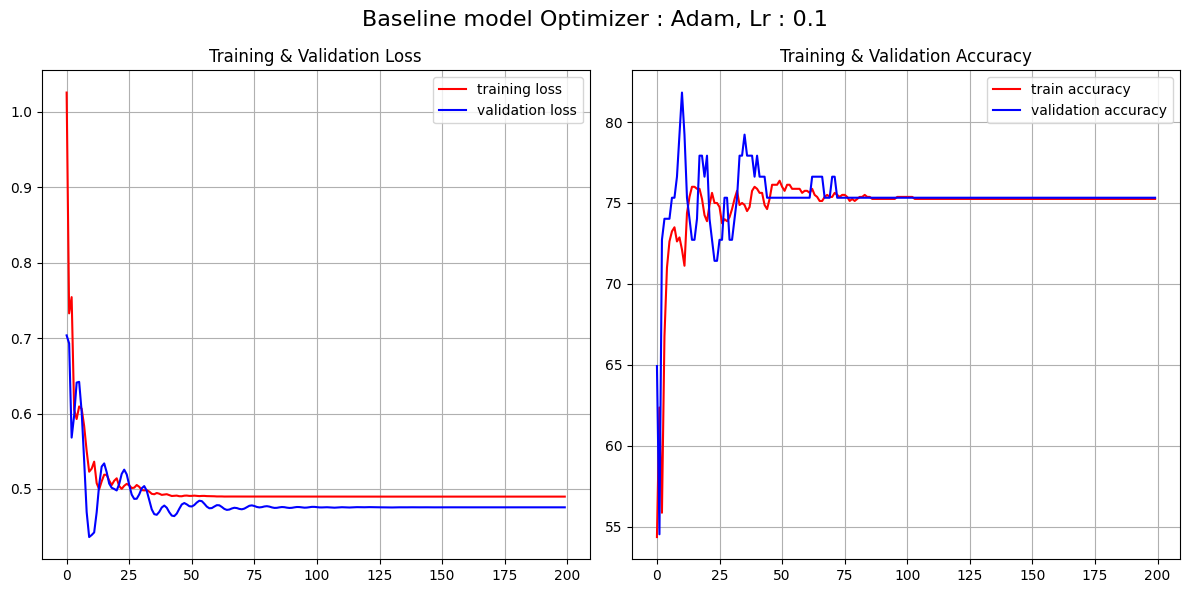

Final Validation Accuracy: 75.3247
Final Validation Loss: 0.4757
Validation Precision: 0.7844
Validation Recall: 0.7532
Validation Specificity: 0.7200
Validation F1 Score: 0.7587


In [18]:


model = Perceptron(input_size=8).to(device)
loss_fn = nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(params=model.parameters(), 
                            lr=0.1)



train_acc, train_loss, validation_loss, validation_acc = run_training(
    num_epochs=200, 
    model=model, 
    loss_fn=loss_fn, 
    optimizer=optimizer,
    X_train=X_train,
    y_train=y_train, 
    validation=(X_val, y_val)
)

# Plot the loss and accuracy curves
title = 'Baseline model Optimizer : Adam, Lr : 0.1'
plot_loss_curves(train_acc, train_loss, validation_acc, validation_loss, title)

# Print final validation metrics
print(f"Final Validation Accuracy: {validation_acc[-1]:.4f}")
print(f"Final Validation Loss: {validation_loss[-1]:.4f}")

precision, recall, specificity, f1 = calculate_metrics(model,X_val, y_val)


# Hyperparameter Optimization


Hyperparameters
learning_rates = [0.01, 0.001, 0.0001, 0.1] <br>
optimizers = ['Adam', 'SGD'] <br>


In [19]:

# Hyperparameters
learning_rates = [0.01, 0.001, 0.0001, 0.1]
optimizers = ['Adam', 'SGD']
best_model = None
best_validation_acc = 0.0
best_optimizer = ""
best_lr = 0
best_loss_function = ""
number_of_features = len(X.columns.tolist())

In [20]:
def track_validation_performance(validation_acc, model, optimizer: str, lossfn: str, lr, X_train):
    """ Tracks and updates the best validation accuracy and saves the best model's state.

    Args:
        validation_acc (list): A list of validation accuracy values over epochs.
        model (torch.nn.Module): The trained model to track and save if validation improves.
        optimizer (str): The name of the optimizer used (e.g., 'Adam', 'SGD').
        lossfn (str): The name of the loss function used (e.g., 'CrossEntropy').
        lr (float): The learning rate used during training.
        X_train (torch.Tensor): The training data, used to determine the number of features.

    Returns:
        None: This function updates global variables with the best performing model and saves the best model to a file.
    """
    global best_validation_acc, best_model, best_optimizer, best_lr, best_loss_function, number_of_features
    final_validation_acc = validation_acc[-1]
    print(f"Validation Accuracy : {final_validation_acc}")
    if final_validation_acc > best_validation_acc:
        best_validation_acc = final_validation_acc  
        best_model = copy.deepcopy(model)  
        best_optimizer = optimizer 
        best_lr = lr  
        best_loss_function = lossfn 
        number_of_features = X_train.shape[1]

        # clearing old model weights 
        pth_files = glob.glob("*.pth")
        for file in pth_files:
            os.remove(file)
        
        # saving the best weight of the best model 
        model_file_name = f"best_model_{best_optimizer}_lr{best_lr}_loss_{best_loss_function}_features{number_of_features}.pth"
        torch.save(best_model.state_dict(), model_file_name)

    return best_validation_acc, best_model, best_optimizer, best_lr, best_loss_function,number_of_features


def train_and_evaluate(optimizer_name, lr, X_train, y_train, validation):
    """Args:
        optimizer_name (str): Name of the optimizer to use ('Adam' or 'SGD').
        lr (float): Learning rate for the optimizer.
        X_train (pd.DataFrame): Training data input features.
        y_train (pd.Series): Training data labels.
        validation (tuple): A tuple containing validation input features and labels (X_val, y_val).
        label_smoothing (float, optional): The amount of label smoothing to apply to loss function. Defaults to 0.0.

    Raises:
        ValueError: If an unsupported optimizer is provided.

    Returns:
        object: The best model or performance metrics after evaluation
    """
    print(f"----------------Optimizer : {optimizer_name}, lr : {lr} ----------------------------")
    
    # Initialize model, loss function, and optimizer
    model = Perceptron(input_size=len(X.columns.tolist())).to(device)
    loss_fn = nn.CrossEntropyLoss()
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")
    
    # Train the model
    train_acc, train_loss, validation_loss, validation_acc = run_training(
        num_epochs=200, model=model, loss_fn=loss_fn, optimizer=optimizer, X_train = X_train, y_train = y_train, validation = validation)
    
    # Plot loss curves
    title = f'LR = {lr} Optimizer : {optimizer_name}'
    plot_loss_curves(train_acc, train_loss, validation_acc, validation_loss, title)
    
    # Track best model performance
    lossfn_desc = 'cross entropy' 
    return track_validation_performance(
        validation_acc, model, optimizer=optimizer_name, lossfn=lossfn_desc, lr=lr, X_train = X_train)

def run_optimizer_experiments(optimizer_name, learning_rates,X_train, y_train, validation):
    """Runs experiments with different learning rates using a specified optimizer and tracks the best-performing model.

    Args:
        optimizer_name (str): The name of the optimizer to use (e.g., 'Adam' or 'SGD').
        learning_rates (list[float]): A list of learning rates to experiment with.
        X_train (pd.DataFrame): Training data input features.
        y_train (pd.Series): Training data labels.
        validation (tuple): A tuple containing validation input features and labels (X_val, y_val).

    Returns:
        tuple: A tuple containing the following:
            best_validation_acc (float): The highest validation accuracy achieved during the experiments.
            best_model (nn.Module): The model that achieved the highest validation accuracy.
            best_optimizer (str): The optimizer that was used for the best model.
            best_lr (float): The learning rate that resulted in the highest validation accuracy.
            best_loss_function (str): The loss function used during the experiment.
            number_of_features (int): The number of features used by the model.
    """
    best_validation_acc = 0
    best_model = None
    best_optimizer = None
    best_lr = None
    best_loss_function = None
    number_of_features = None
    
    for lr in learning_rates:
        
        validation_acc, model, optimizer, lr_used, lossfn_used, num_features = train_and_evaluate(optimizer_name = optimizer_name , 
                                                                                                  lr = lr, 
                                                                                                  X_train = X_train,
                                                                                                  y_train = y_train, 
                                                                                                  validation = validation)
        if validation_acc > best_validation_acc:
            best_validation_acc, best_model, best_optimizer, best_lr, best_loss_function, number_of_features = \
                validation_acc, model, optimizer, lr_used, lossfn_used, num_features



    return best_validation_acc, best_model, best_optimizer, best_lr, best_loss_function, number_of_features

Using Adam optimizer
----------------Optimizer : Adam, lr : 0.01 ----------------------------


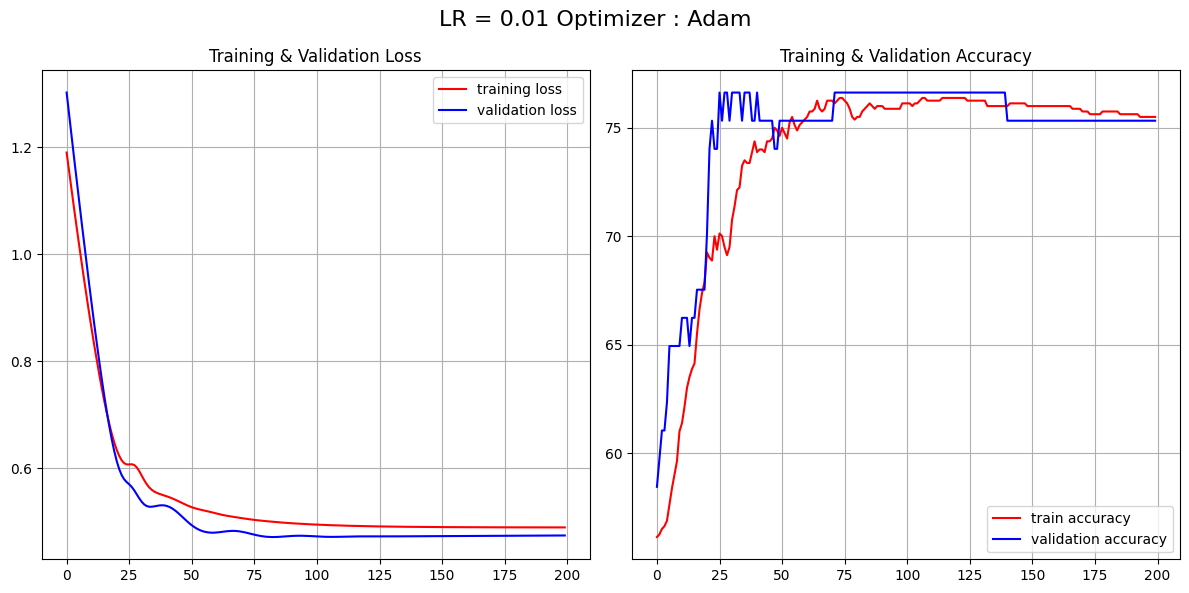

Validation Accuracy : 75.32467532467533
----------------Optimizer : Adam, lr : 0.001 ----------------------------


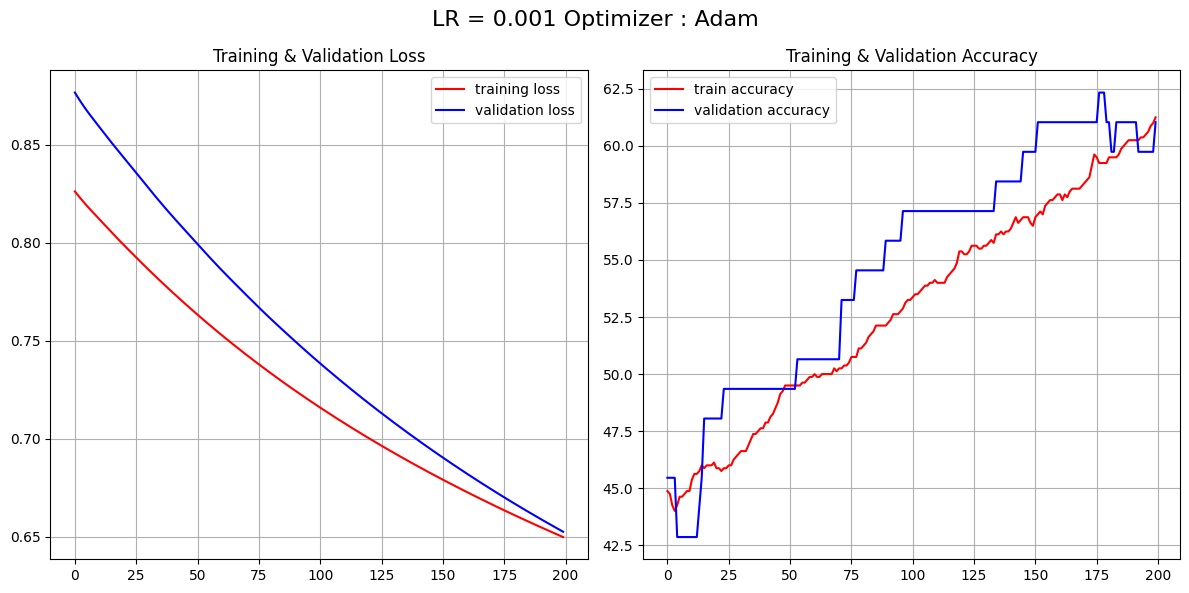

Validation Accuracy : 61.038961038961034
----------------Optimizer : Adam, lr : 0.0001 ----------------------------


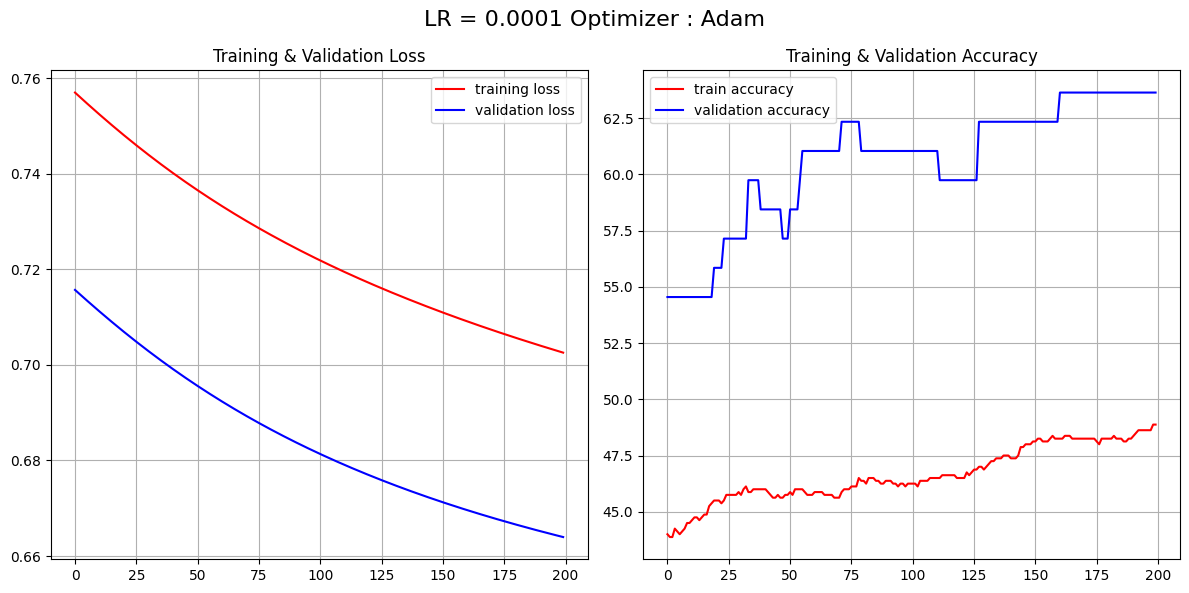

Validation Accuracy : 63.63636363636363
----------------Optimizer : Adam, lr : 0.1 ----------------------------


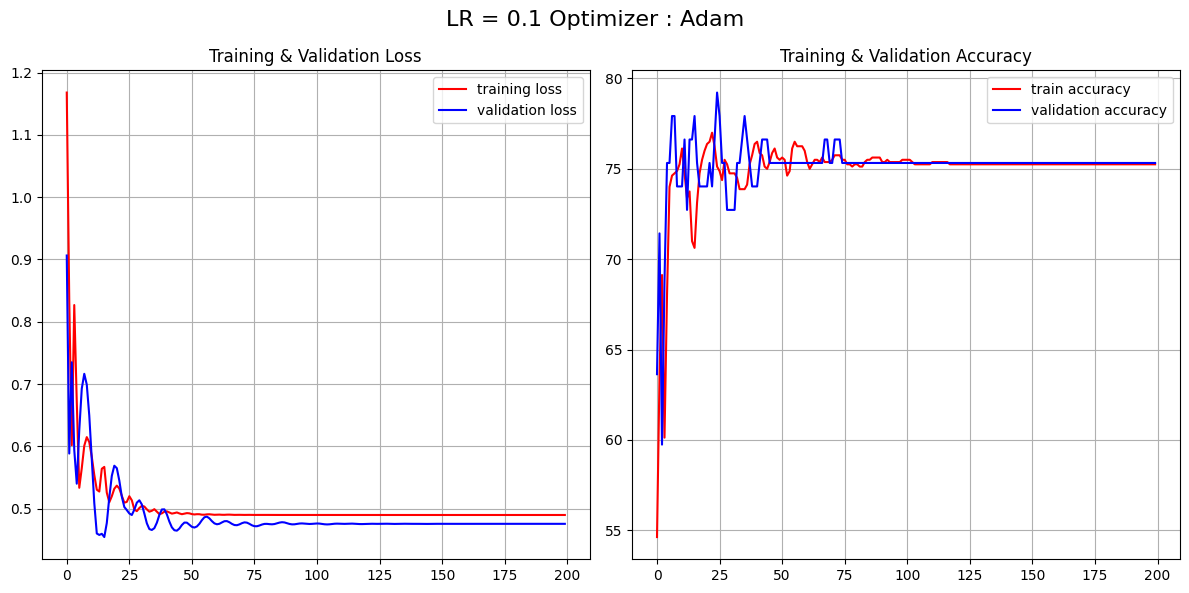

Validation Accuracy : 75.32467532467533
Using SGD optimizer
----------------Optimizer : SGD, lr : 0.01 ----------------------------


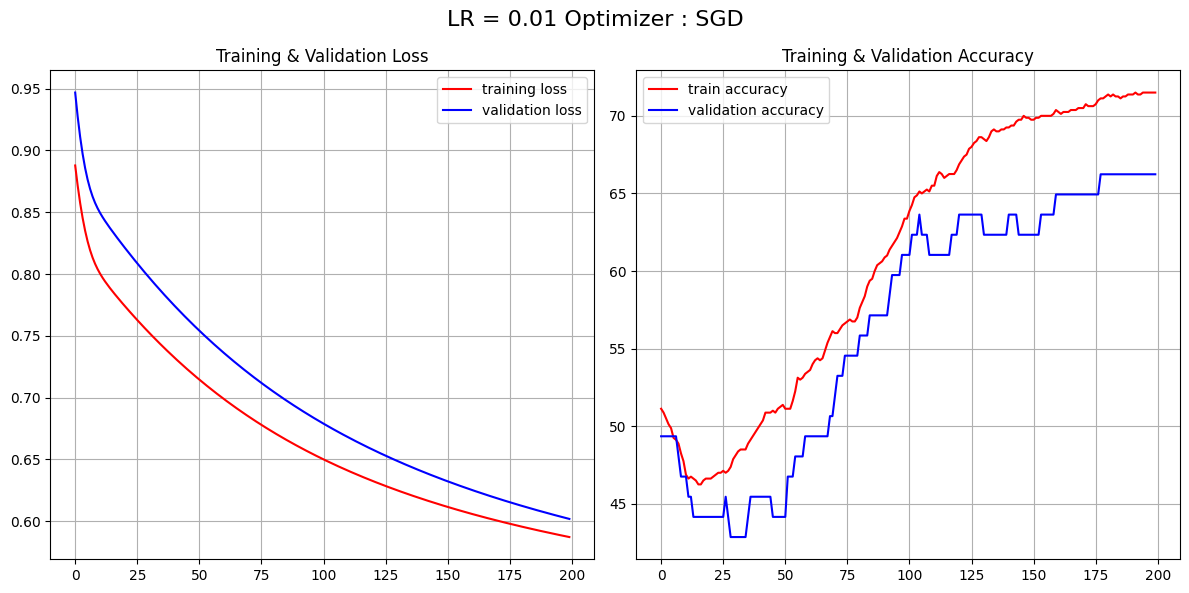

Validation Accuracy : 66.23376623376623
----------------Optimizer : SGD, lr : 0.001 ----------------------------


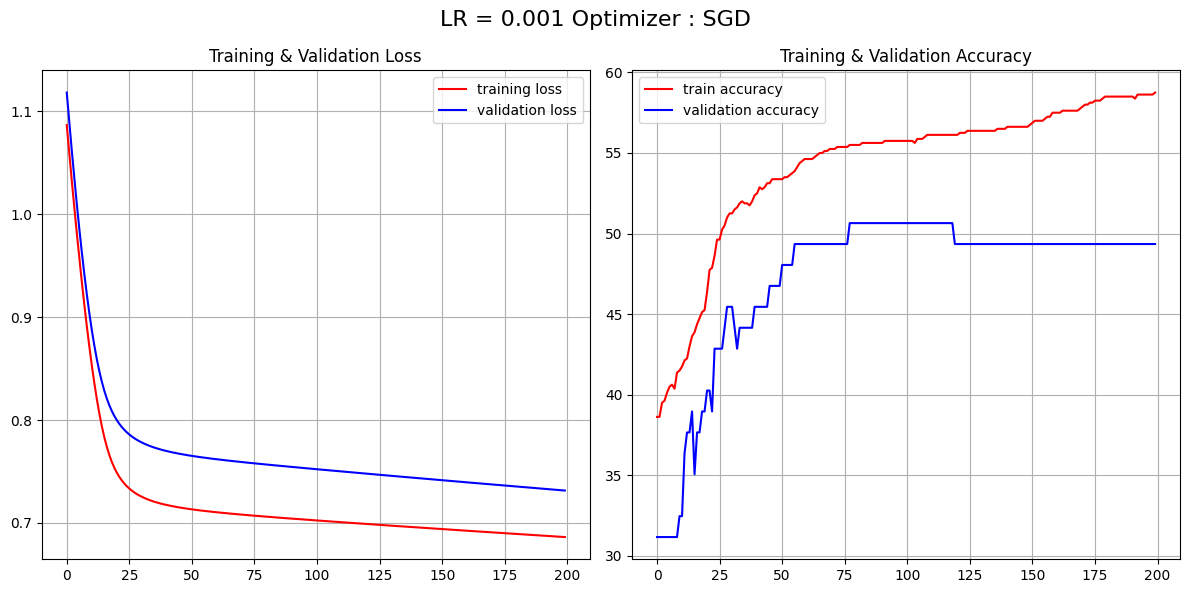

Validation Accuracy : 49.35064935064935
----------------Optimizer : SGD, lr : 0.0001 ----------------------------


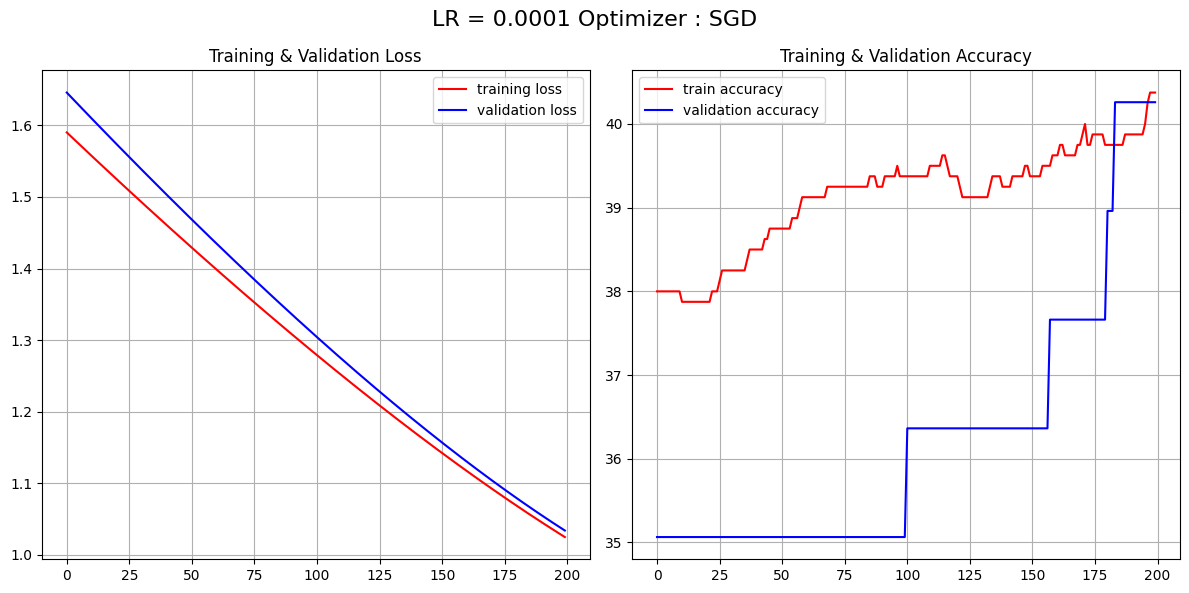

Validation Accuracy : 40.25974025974026
----------------Optimizer : SGD, lr : 0.1 ----------------------------


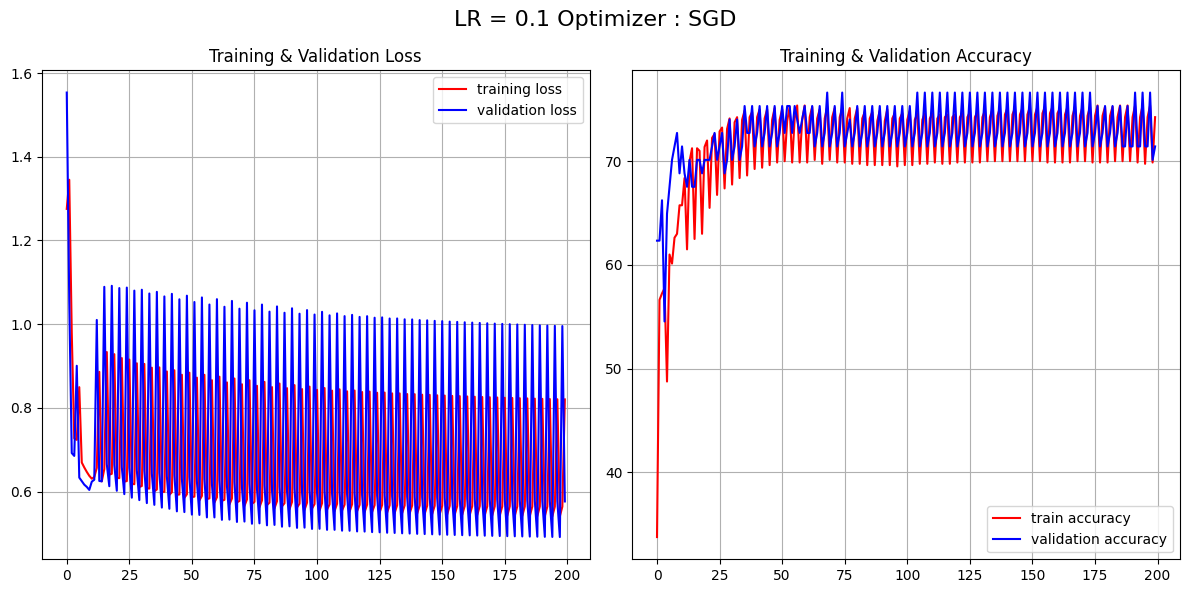

Validation Accuracy : 71.42857142857143
Best model found with Adam optimizer, learning rate 0.01, and cross entropy. Best validation accuracy: 75.32467532467533, num_features: 8
Validation Precision: 0.7844
Validation Recall: 0.7532
Validation Specificity: 0.7200
Validation F1 Score: 0.7587


In [21]:
for optimizer in optimizers:
    print(f"Using {optimizer} optimizer")
    
    best_validation_acc, best_model, best_optimizer, best_lr, best_loss_function, number_of_features = run_optimizer_experiments(
        optimizer_name=optimizer,
        learning_rates=learning_rates,
        X_train=X_train,
        y_train=y_train,
        validation=(X_val, y_val)
    )
print(f"Best model found with {best_optimizer} optimizer, learning rate {best_lr}, "
  f"and {best_loss_function}. Best validation accuracy: {best_validation_acc}, num_features: {number_of_features}")
_, _, _, _= calculate_metrics(model = best_model, X_val = X_val, y_val = y_val)
    

## Refining feature set to improve model performance

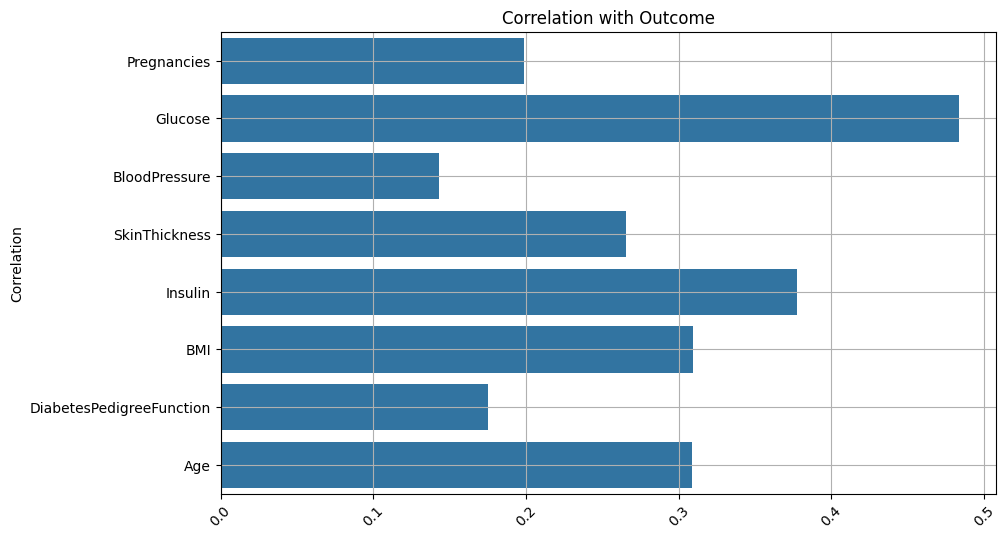

In [28]:
# plotting correlations
correlations = df.corr(method = 'pearson')['Outcome'].drop('Outcome') 
plt.figure(figsize=(10, 6))
sns.barplot(y=correlations.index, x=correlations.values)
plt.title('Correlation with Outcome')
plt.xticks(rotation=45)
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

In [23]:
# refined feature set: removing features with correlation < 0.1
X = df[correlations[correlations > 0.1].index.tolist()]
y = df['Outcome'].values

# preparing train, test and validation set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11, random_state=42, stratify=y_train_val)



# data imputing imputing and scaling
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', RobustScaler())  
])


X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)  
X_test = pipeline.transform(X_test)

# applying smote
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# converting to tensor
device = torch.device("mps")

X_train= torch.tensor(X_train_smote, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_smote, dtype=torch.int).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.int).to(device)


Using Adam optimizer
----------------Optimizer : Adam, lr : 0.01 ----------------------------


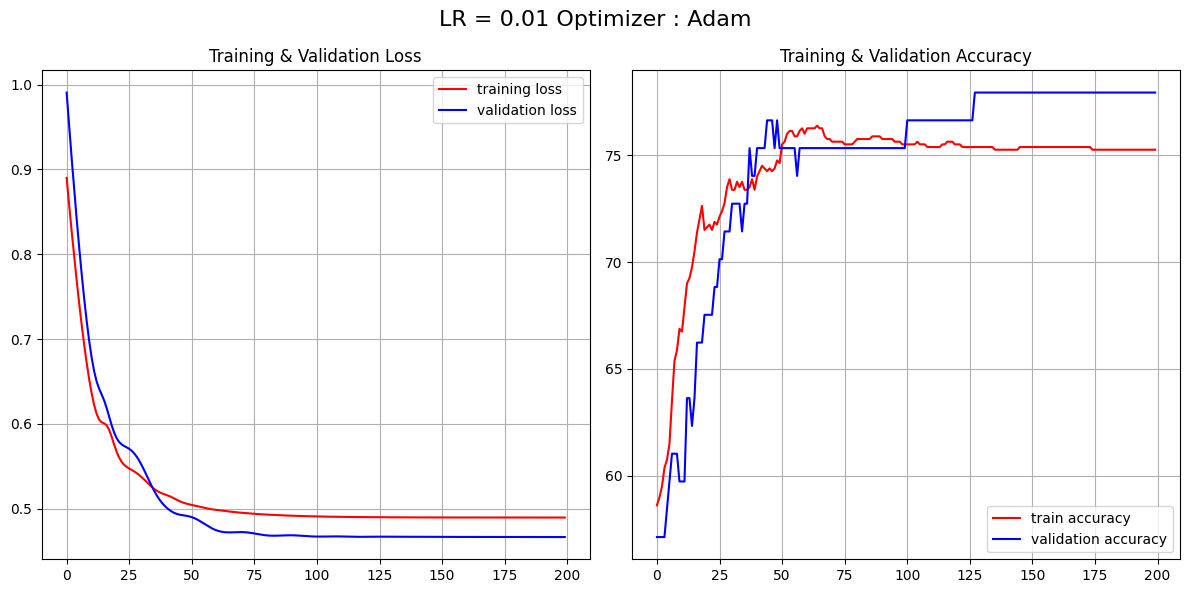

Validation Accuracy : 77.92207792207793
----------------Optimizer : Adam, lr : 0.001 ----------------------------


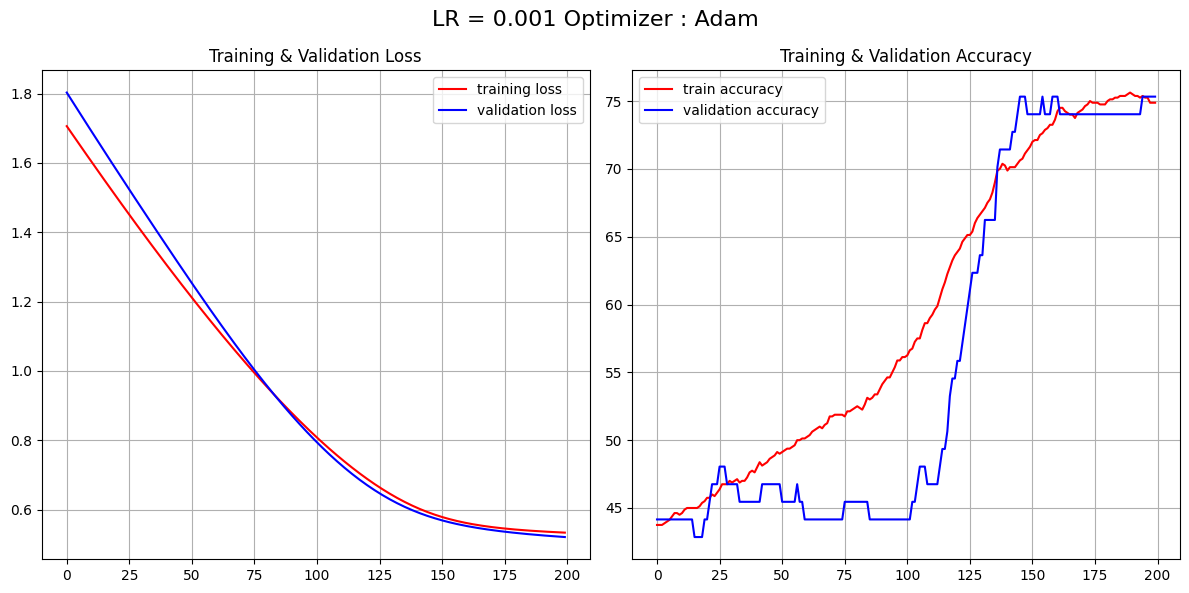

Validation Accuracy : 75.32467532467533
----------------Optimizer : Adam, lr : 0.0001 ----------------------------


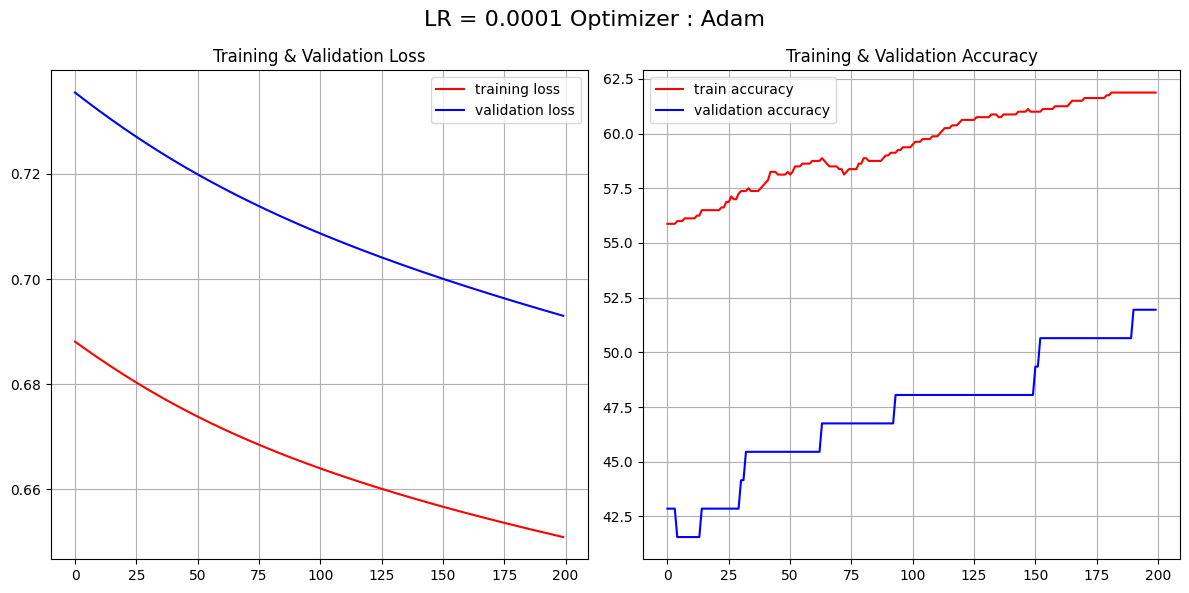

Validation Accuracy : 51.94805194805194
----------------Optimizer : Adam, lr : 0.1 ----------------------------


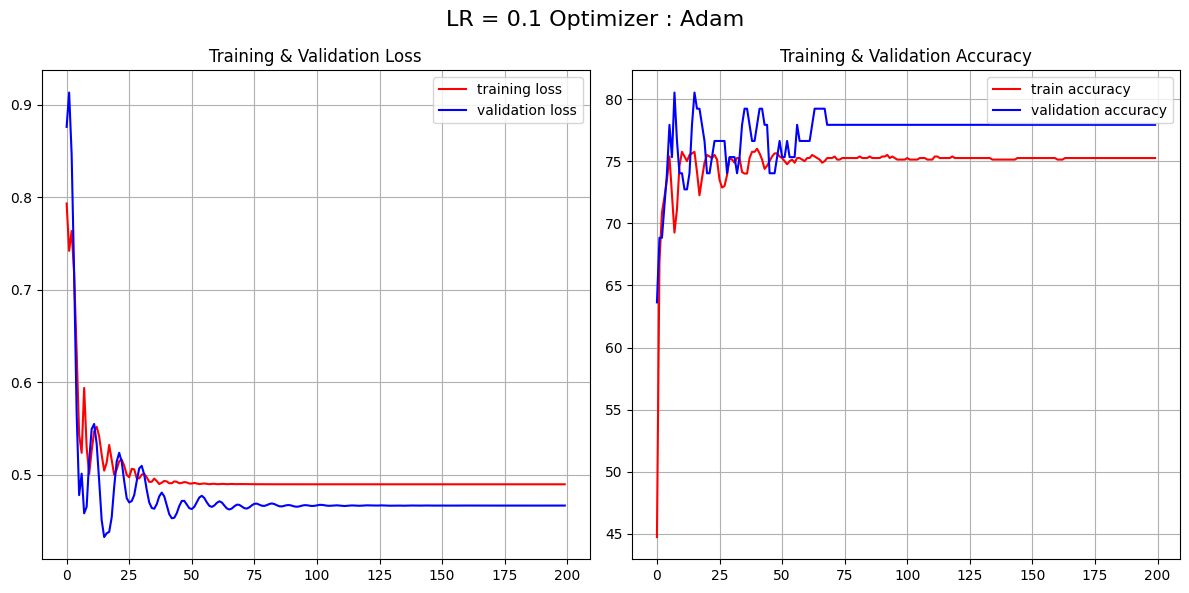

Validation Accuracy : 77.92207792207793
Using SGD optimizer
----------------Optimizer : SGD, lr : 0.01 ----------------------------


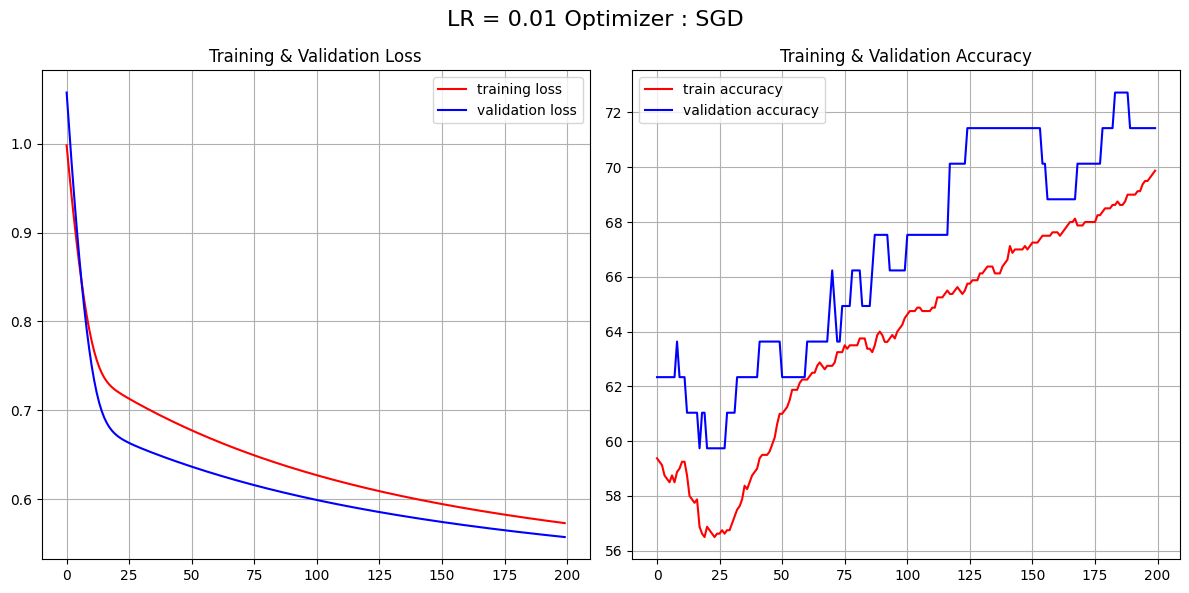

Validation Accuracy : 71.42857142857143
----------------Optimizer : SGD, lr : 0.001 ----------------------------


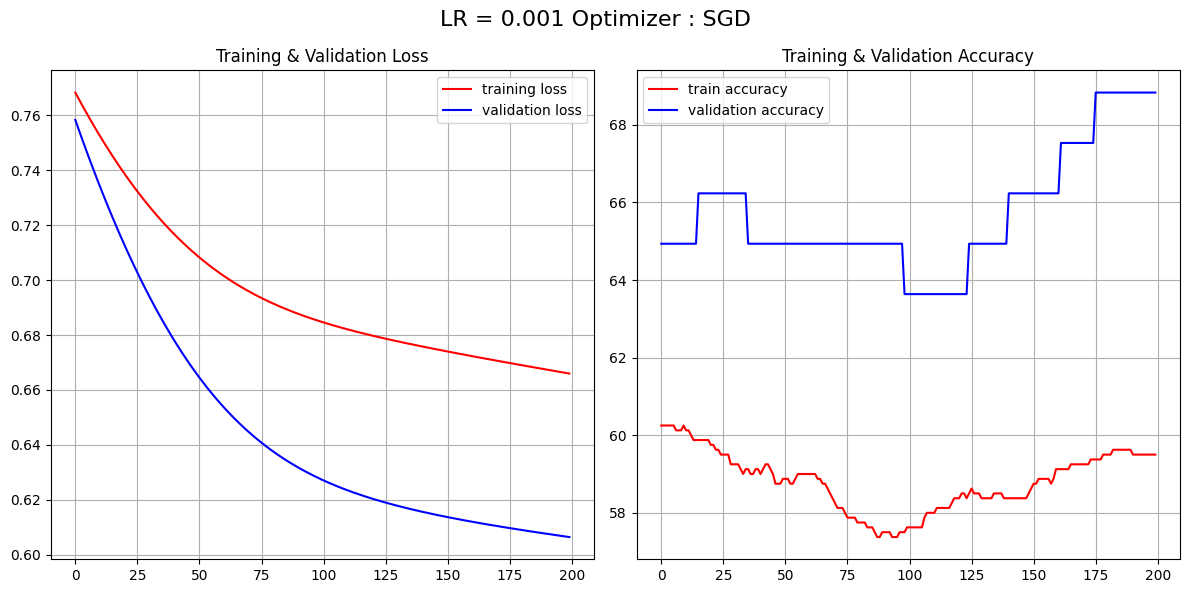

Validation Accuracy : 68.83116883116884
----------------Optimizer : SGD, lr : 0.0001 ----------------------------


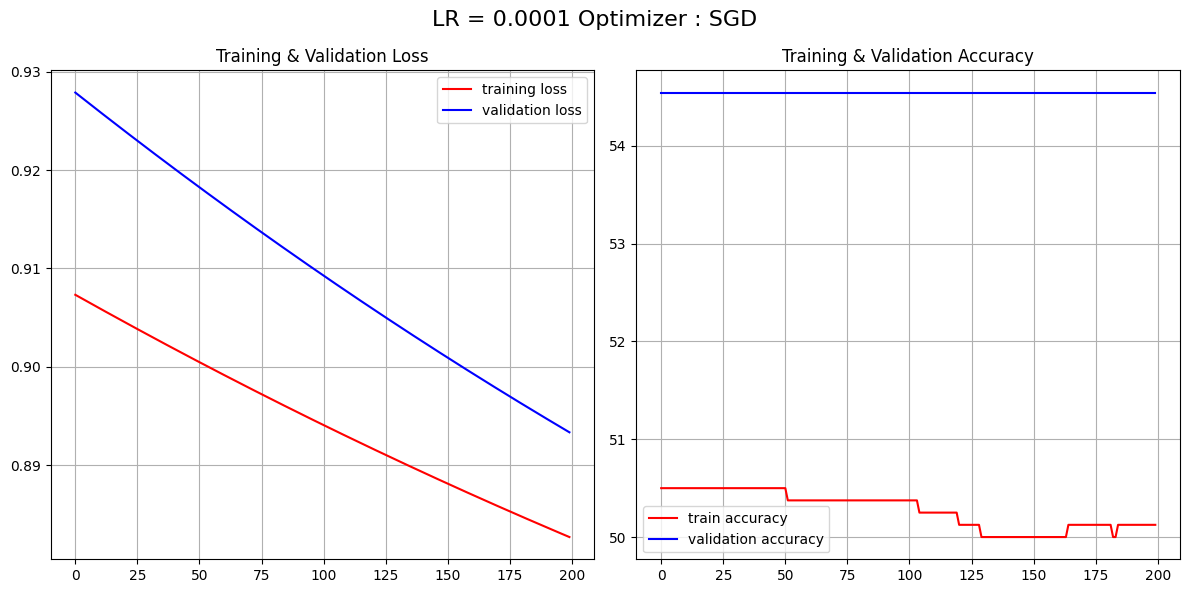

Validation Accuracy : 54.54545454545454
----------------Optimizer : SGD, lr : 0.1 ----------------------------


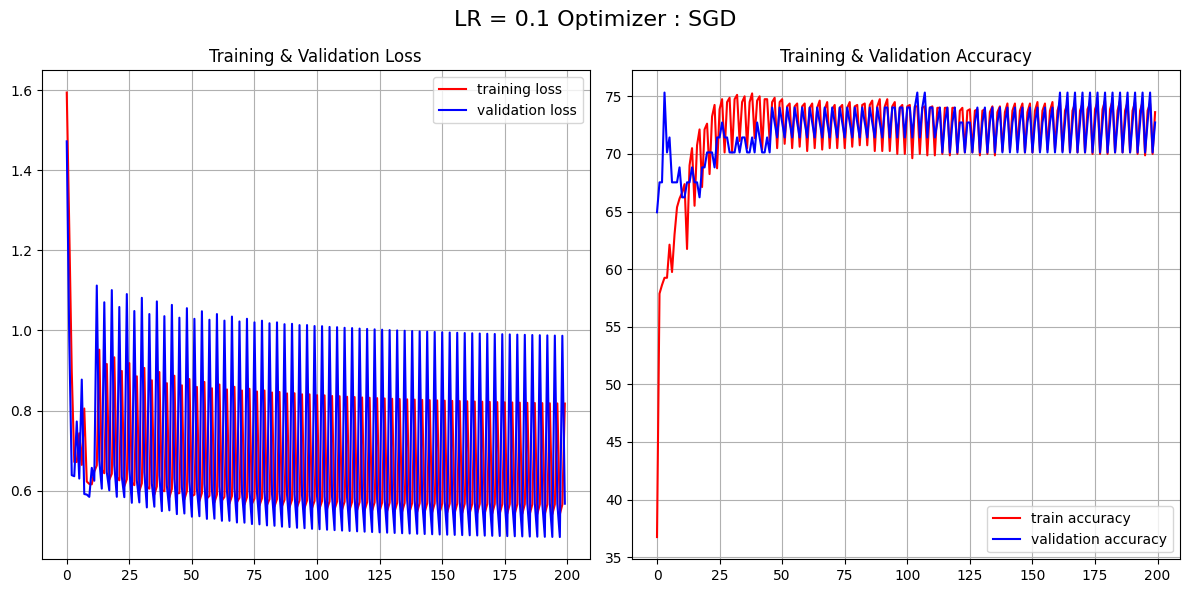

Validation Accuracy : 72.72727272727273
Best model found with Adam optimizer, learning rate 0.01, and cross entropy. Best validation accuracy: 77.92207792207793, num_features: 7
Validation Precision: 0.8007
Validation Recall: 0.7792
Validation Specificity: 0.7600
Validation F1 Score: 0.7836


In [24]:
# iterating through optimizers
for optimizer in optimizers:
    print(f"Using {optimizer} optimizer")
    
    best_validation_acc, best_model, best_optimizer, best_lr, best_loss_function, number_of_features = run_optimizer_experiments(
        optimizer_name=optimizer,
        learning_rates=learning_rates,
        X_train=X_train,
        y_train=y_train,
        validation=(X_val, y_val)
    )
print(f"Best model found with {best_optimizer} optimizer, learning rate {best_lr}, "
      f"and {best_loss_function}. Best validation accuracy: {best_validation_acc}, num_features: {number_of_features}")
_, _, _, _ =calculate_metrics(model = best_model, X_val = X_val, y_val = y_val)

In [25]:
# loading the weights of the best model
model = Perceptron(input_size=7).to(device) 
model.load_state_dict(torch.load('best_model_Adam_lr0.01_loss_cross entropy_features7.pth'))

# predicting on test set
y_preds = model(X_test)
_, val_preds = torch.max(y_preds, 1)


In [26]:
# classification report 
y_test_cpu, test_preds_cpu =y_test.cpu(), val_preds.cpu()

accuracy = accuracy_score(y_test_cpu, test_preds_cpu)
precision = precision_score(y_test_cpu, test_preds_cpu, average='weighted')
recall = recall_score(y_test_cpu, test_preds_cpu, average='weighted')
f1 = f1_score(y_test_cpu, test_preds_cpu, average='weighted')
print(classification_report(y_test_cpu, test_preds_cpu))

# Print individual metrics
print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"Test Set Precision: {precision:.4f}")
print(f"Test Set Recall: {recall:.4f}")
print(f"Test Set F1-Score: {f1:.4f}")

              precision    recall  f1-score   support

           0       0.84      0.76      0.80        50
           1       0.62      0.74      0.68        27

    accuracy                           0.75        77
   macro avg       0.73      0.75      0.74        77
weighted avg       0.77      0.75      0.76        77

Test Set Accuracy: 0.7532
Test Set Precision: 0.7675
Test Set Recall: 0.7532
Test Set F1-Score: 0.7572


Confusion Matrix:


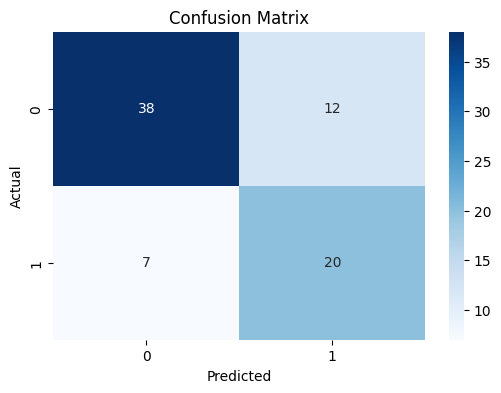

In [27]:
# confusion matrix
y_test_cpu = y_test.cpu()
val_preds_cpu = val_preds.cpu()
conf_matrix = confusion_matrix(y_test_cpu, val_preds_cpu)
tn = conf_matrix[0, 0] 
fp = conf_matrix[0, 1]  
fn = conf_matrix[1, 0]  
tp = conf_matrix[1, 1]  
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
print("Confusion Matrix:")
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
